In [2]:
import datetime as dt
import json
import numpy as np
import pandas as pd
import re
import requests
import tweepy

# Gather

## Gathering Data 1
> Gathering twitter archive from "twitter-archive-enhanced.csv" file.

In [3]:
archive = pd.read_csv("twitter-archive-enhanced.csv")
archive.set_index("tweet_id", inplace = True)
archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## Gathering Data 2
> Using requests, get image related data from given url.

In [4]:
tsv_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(tsv_url)

with open(tsv_url.split('/')[-1], mode = 'wb') as file:
    file.write(r.content)
    
images = pd.read_csv('image-predictions.tsv', sep = '\t')
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Gathering Data 3
> Using tweepy, we get data from twitter api and save data as "tweet_json.txt"

In [5]:
consumer_key = ""
consumer_secret = ""
access_token = ""
access_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [6]:
df = []
exceptions = []
tweet_id = images['tweet_id']

for id in tweet_id:
    try:
        page = api.get_status(id)
        favorites = page['favorite_count']
        retweets = page['retweet_count']
        time = pd.to_datetime(page['created_at'])
        df.append({'tweet_id': int(id),
                        'favorites': int(favorites),
                        'retweets': int(retweets)})
    
    except Exception as e:
        exceptions.append(id)

In [7]:
exceptions

[680055455951884288,
 754011816964026368,
 802247111496568832,
 837012587749474308,
 842892208864923648,
 861769973181624320,
 872261713294495745,
 873697596434513921,
 888202515573088257]

In [8]:
exceptions2 = []
for e in exceptions:
    try:
        page = api.get_status(e)
        favorites = page['favorite_count']
        retweets = page['retweet_count']
        time = pd.to_datetime(page['created_at'])
        df.append({'tweet_id': int(e),
                        'favorites': int(favorites),
                        'retweets': int(retweets)})
        
    except Exception:
        exceptions2.append(id)

In [9]:
df = pd.DataFrame(df, columns = ['tweet_id', 'favorites', 'retweets'])
df.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [10]:
df = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
df.set_index('tweet_id', inplace = True)
df.tail()

,favorites,retweets
tweet_id,,
891327558926688256,39340,9094
891689557279858688,41158,8390
891815181378084864,24455,4029
892177421306343426,32490,6091
892420643555336193,37807,8246


In [11]:
images.set_index('tweet_id', inplace = True)
df2 = pd.merge(left=archive, right=images, left_index=True, right_index=True, how='left')
df2 = pd.merge(left=df2, right=df, left_index=True, right_index=True, how='left')
df2.to_csv('df2copy.csv', encoding = 'utf-8')

# Assess

## Assessing data 1

In [12]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), object(10)
memory usa

In [13]:
archive.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Penny        10
Lola         10
Tucker       10
Winston       9
Bo            9
the           8
Sadie         8
an            7
Buddy         7
Daisy         7
Bailey        7
Toby          7
Milo          6
Rusty         6
Jax           6
Scout         6
Oscar         6
Leo           6
Bella         6
Dave          6
Koda          6
Jack          6
Stanley       6
Gus           5
           ... 
Ebby          1
Gin           1
Molly         1
Dunkin        1
Shikha        1
Sage          1
Kona          1
Biden         1
Antony        1
Willem        1
Blipson       1
Stormy        1
Ronduh        1
Chase         1
Tilly         1
Monty         1
such          1
Ben           1
Howie         1
Bodie         1
Harry         1
Vinscent      1
Barry         1
Kota          1
Ozzie         1
Buckley       1
Ester         1
Crumpet       1
Barclay       1
Crouton       1
Name: name, Length: 957,

In [14]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [15]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## Assessing Data 2

In [17]:
images.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
jpg_url    2075 non-null object
img_num    2075 non-null int64
p1         2075 non-null object
p1_conf    2075 non-null float64
p1_dog     2075 non-null bool
p2         2075 non-null object
p2_conf    2075 non-null float64
p2_dog     2075 non-null bool
p3         2075 non-null object
p3_conf    2075 non-null float64
p3_dog     2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 232.0+ KB


In [18]:
tweet = pd.read_csv("tweet_json.txt", encoding = 'utf-8')
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 3 columns):
tweet_id     2066 non-null int64
favorites    2066 non-null int64
retweets     2066 non-null int64
dtypes: int64(3)
memory usage: 48.5 KB


### Quality
> 1. The name column does not contain proper names such as "a".
2. The timestamp column should be datetime type.
3. Some null values are not treated as null values.
4. Some numerators and denumerators have unusual values.
5. Several columns have empty values, like in_reply_to_status, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.
6. Images dataframe has 2075 entries while archive only has 2356 entries.
7. There are retweets and tweets without images.
8. Columns for dog breed predictions need to be reworked(condensed)

### Tidiness
> 1. The dog stages(doggo, puppo, etc.) have values as columns, instead of one column filled with their values.
2. 3 dataframes are not needed so I merged them since they are all related to one twitter account

# Clean

In [19]:
df_clean = pd.read_csv("df2copy.csv")

### Define:
### Remove retweets and tweets without images
### Code:

In [20]:
# remove tweets without images
df_clean = df_clean[pd.notnull(df_clean['jpg_url'])]

In [21]:
# remove retweets
df_clean = df_clean[pd.isnull(df_clean['retweeted_status_id'])]
df_clean.shape[0]

1994

In [22]:
df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

### Test:

In [23]:
df_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorites', 'retweets'],
      dtype='object')

### Define:
### Convert timestamp to datetime object
### Code:

In [24]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

### Test:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 666020888022790149 to 892420643555336193
Data columns (total 2 columns):
favorites    2066 non-null int64
retweets     2066 non-null int64
dtypes: int64(2)
memory usage: 128.4 KB


### Define:
### Extract "real" names and remove invalid names
### Code:

In [26]:
df_clean['text_split'] = df_clean['text'].str.split()

In [27]:
names = []

# use string starts with method to clean this up

def get_names(row):
    
    # 'named John'           
    if 'named' in row['text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
    
    # 'Here we have John'
    elif row['text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
            
    # 'This is John'
    elif row['text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    
    # 'Say hello to John'
    elif row['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    # 'Meet John'
    elif row['text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
            
    else:
        names.append('Nameless')
        
        
df_clean.apply(get_names, axis=1)

df_clean['names'] = names

In [28]:
df_clean.names.value_counts()

Nameless        625
Charlie          11
Cooper           10
Oliver           10
Lucy             10
Penny             9
Tucker            9
Sadie             8
Winston           8
Daisy             7
Lola              7
Bella             6
Stanley           6
Koda              6
Toby              6
Jax               6
Bo                6
Chester           5
Bailey            5
Milo              5
Buddy             5
Leo               5
Louis             5
Scout             5
Oscar             5
Rusty             5
Winnie            4
Derek             4
Duke              4
Larry             4
               ... 
Tedrick           1
Goliath           1
Tayzie            1
Jarvis            1
Dotsy             1
Jomathan          1
Ulysses           1
Butter            1
Alf               1
Sailer            1
Akumi             1
Joshwa            1
Joey              1
Corey             1
Marlee            1
Zoe               1
Willie            1
Alexanderson      1
Hercules          1


In [29]:
df_clean.drop(['text_split'], axis=1, inplace=True)

### Test:

In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 28 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2            

### Define:
### Merge dog type columns 
### Code:

In [31]:
dog_type = []

a = ['pupper', 'puppo', 'doggo', 'floof']
b = ['pupper', 'puppo', 'doggo', 'floof']

for row in df_clean['text']:
    row = row.lower()
    for word in a:
        if word in str(row):
            dog_type.append(b[a.index(word)])
            break
    else:
        dog_type.append('None')

df_clean['dog_type'] = dog_type

In [32]:
df_clean.dog_type.value_counts()

None      1625
pupper     237
doggo       69
floof       34
puppo       29
Name: dog_type, dtype: int64

In [33]:
df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

### Test:

In [34]:
df_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'favorites', 'retweets', 'names', 'dog_type'],
      dtype='object')

### Define:
### Condense dog breed predictions  
### Code:

In [35]:
breed = []
conf= []

def breed_conf(row):
    if row['p1_dog']:
        breed.append(row['p1'])
        conf.append(row['p1_conf'])
    elif row['p2_dog']:
        breed.append(row['p2'])
        conf.append(row['p2_conf'])
    elif row['p3_dog']:
        breed.append(row['p3'])
        conf.append(row['p3_conf'])
    else:
        breed.append('Unidentifiable')
        conf.append(0)

df_clean.apply(breed_conf, axis = 1)

df_clean['breed'] = breed
df_clean['confidence'] = conf

In [36]:
df_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',], axis=1, inplace=True)

### Test:

In [37]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,favorites,retweets,names,dog_type,breed,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,37807.0,8246.0,Phineas,None,Unidentifiable,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,32490.0,6091.0,Tilly,None,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,24455.0,4029.0,Archie,None,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,41158.0,8390.0,Darla,None,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,39340.0,9094.0,Franklin,None,basset,0.555712


### Define:
### Remove unnecessary columns 
### Code:

In [38]:
df_clean['in_reply_to_status_id'].value_counts()

6.671522e+17    2
8.558181e+17    1
6.753494e+17    1
6.747934e+17    1
6.747522e+17    1
7.468859e+17    1
6.706684e+17    1
6.844811e+17    1
6.749998e+17    1
6.842229e+17    1
7.291135e+17    1
6.754971e+17    1
6.717299e+17    1
6.715610e+17    1
7.030419e+17    1
6.757073e+17    1
7.590995e+17    1
6.914169e+17    1
7.032559e+17    1
6.678065e+17    1
6.920419e+17    1
7.331095e+17    1
Name: in_reply_to_status_id, dtype: int64

In [39]:
df_clean['in_reply_to_user_id'].value_counts()

4.196984e+09    23
Name: in_reply_to_user_id, dtype: int64

In [40]:
df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

### Test:

In [41]:
df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'favorites', 'retweets', 'names', 'dog_type', 'breed', 'confidence'],
      dtype='object')

### Define:
### Extract Dog rates and counts
### Code:

In [42]:
rates = []

#raw_rates = lambda x: rates.append(re.findall(r'(\d+(\.\d+)|(\d+))\/(\d+0)', x, flags=0))

df_clean['text'].apply(lambda x: rates.append(re.findall(r'(\d+(\.\d+)|(\d+))\/(\d+0)', x, flags=0)))

rating = []
dog_count = []

for rate in rates:
    
    # for tweets with no rating, but a picture, so a dog_count of 1
    if len(rate) == 0:
        rating.append('NaN')
        dog_count.append(1)
        
    # for tweets with single rating and dog_count of 1
    elif len(rate) == 1 and rate[0][-1] == '10':
        rating.append(float(rate[0][0]))
        dog_count.append(1)
   
    # for multiple ratings
    elif len(rate) == 1: 
        a = float(rate[0][0]) / (float(rate[0][-1]) / 10) 
        rating.append(a)
        dog_count.append(float(rate[0][-1]) / 10)
   
    # for tweets with more than one rating
    elif len(rate) > 1: 
        total = 0
        r = []
        for i in range(len(rate)):
            if rate[i][-1] == '10': #one tweet has the phrase '50/50' so I'm coding to exclude it
                r.append(rate[i])
        for num in r:
            total = total + float(num[0])
        a = total / len(rate)
        rating.append(a)
        dog_count.append(len(rate))
   
    # if any error has occurred
    else:
        rating.append('Not parsed')
        dog_count.append('Not parsed') 
        
df_clean['rating'] = rating # not need to also add denominator since they are all 10!
df_clean['dog_count'] = dog_count
df_clean['rating'].value_counts()

12.0                 453
10.0                 411
11.0                 399
13.0                 261
9.0                  152
8.0                   94
7.0                   52
14.0                  36
6.0                   32
5.0                   30
3.0                   19
4.0                   14
2.0                    9
8.5                    4
1.0                    4
7.5                    3
9.5                    3
5.5                    2
6.5                    2
10.5                   2
0.0                    2
NaN                    1
9.75                   1
1776.0                 1
4.5                    1
11.27                  1
13.5                   1
420.0                  1
11.5                   1
9.666666666666666      1
11.26                  1
Name: rating, dtype: int64

In [43]:
df_clean.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

### Test:

In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id         1994 non-null int64
timestamp        1994 non-null datetime64[ns]
source           1994 non-null object
text             1994 non-null object
expanded_urls    1994 non-null object
name             1994 non-null object
jpg_url          1994 non-null object
img_num          1994 non-null float64
favorites        1991 non-null float64
retweets         1991 non-null float64
names            1994 non-null object
dog_type         1994 non-null object
breed            1994 non-null object
confidence       1994 non-null float64
rating           1994 non-null object
dog_count        1994 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(9)
memory usage: 264.8+ KB


In [45]:
df_clean['dog_count'].value_counts()

1.0     1958
2.0       23
5.0        2
8.0        2
3.0        1
12.0       1
11.0       1
13.0       1
4.0        1
9.0        1
17.0       1
15.0       1
7.0        1
Name: dog_count, dtype: int64

In [46]:
df_clean.loc[df_clean['names'] == 'Nameless', 'names'] = None
df_clean.loc[df_clean['breed'] == 'Unidentifiable', 'breed'] = None
df_clean.loc[df_clean['dog_type'] == 'None', 'dog_type'] = None
df_clean.loc[df_clean['rating'] == 0.0, 'rating'] = np.nan
df_clean.loc[df_clean['confidence'] == 0.0, 'confidence'] = np.nan
df_clean.drop(['name'], axis=1, inplace=True)

In [60]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id         1994 non-null int64
timestamp        1994 non-null datetime64[ns]
source           1994 non-null object
text             1994 non-null object
expanded_urls    1994 non-null object
jpg_url          1994 non-null object
img_num          1994 non-null float64
favorites        1991 non-null float64
retweets         1991 non-null float64
names            1369 non-null object
dog_type         369 non-null object
breed            1686 non-null object
confidence       1686 non-null float64
rating           1992 non-null object
dog_count        1994 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(8)
memory usage: 249.2+ KB


In [61]:
df_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,jpg_url,img_num,favorites,retweets,names,dog_type,breed,confidence,rating,dog_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,37807.0,8246.0,Phineas,None,None,NaN,13,1.0
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,32490.0,6091.0,Tilly,None,Chihuahua,0.323581,13,1.0


In [48]:
#Save file to csv
df_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8')

## Analysis

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
data = pd.read_csv('twitter_archive_master.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

### Dog stage 

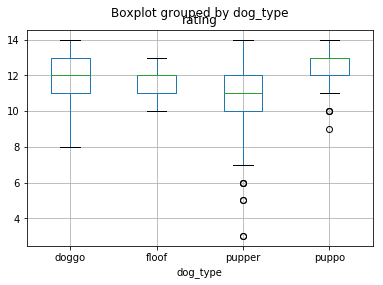

In [51]:
data.boxplot(column='rating', by='dog_type');

In [52]:
data.groupby('dog_type')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_type,,,,,,,,
doggo,69.0,11.797101,1.510548,8.0,11.0,12.0,13.0,14.0
floof,34.0,11.705882,0.759961,10.0,11.0,12.0,12.0,13.0
pupper,237.0,10.616160,1.833623,3.0,10.0,11.0,12.0,14.0
puppo,29.0,12.172414,1.197288,9.0,12.0,13.0,13.0,14.0


> Puppers in general get lower ratings than other types while Puppos get higher ratings in average. Puppers are the most common type, but puppos are the rarest.

### Most rated breeds

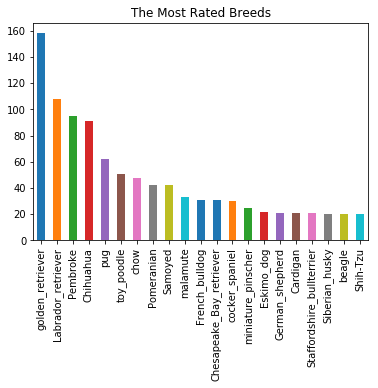

In [53]:
top=data.groupby('breed').filter(lambda x: len(x) >= 20)
top['breed'].value_counts().plot(kind = 'bar')
plt.title('The Most Rated Breeds');

> Golden retriever has the highest ratings. However, there is no logical background that I can explain why those breeds are top most rated ones.

In [54]:
top.groupby('breed')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
breed,,,,,,,,
Cardigan,21.0,11.142857,1.590148,7.0,10.00,11.00,12.0,13.0
Chesapeake_Bay_retriever,31.0,10.741935,1.510358,8.0,10.00,10.00,12.0,13.0
Chihuahua,91.0,10.516484,2.071568,3.0,9.50,11.00,12.0,14.0
Eskimo_dog,22.0,11.409091,1.402688,9.0,10.00,12.00,12.0,14.0
French_bulldog,31.0,11.193548,1.796652,8.0,10.00,12.00,12.0,14.0
German_shepherd,21.0,11.000000,1.449138,8.0,10.00,11.00,12.0,13.0
Labrador_retriever,108.0,11.180556,1.324567,7.0,10.00,11.00,12.0,14.0
Pembroke,95.0,11.389474,1.746088,4.0,11.00,12.00,12.0,14.0
Pomeranian,42.0,10.779762,1.619435,6.0,10.00,11.00,12.0,14.0


In [55]:
data['rating'].describe()

count    1991.000000
mean       11.647638
std        40.668547
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating, dtype: float64

In [56]:
data[data['rating'] <= 14]['rating'].describe()

count    1989.000000
mean       10.555277
std         2.157977
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating, dtype: float64

> Only one breed among top rated breeds has higher mean than the total population mean. This happens because of outlier such as 1776. Removing that lowers mean to 10.56.

### Retweets, favorites and ratings correlations

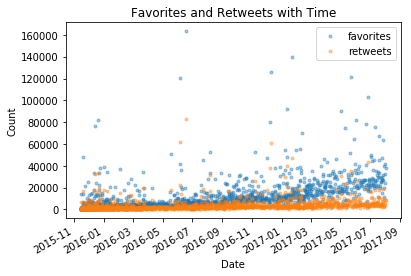

In [57]:
data[['favorites', 'retweets']].plot(style = '.', alpha = 0.4)
plt.title('Favorites and Retweets with Time')
plt.xlabel('Date')
plt.ylabel('Count');

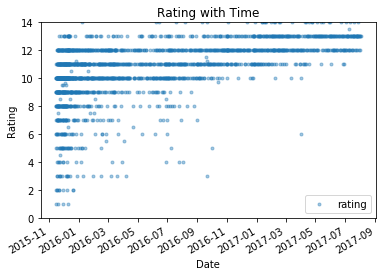

In [58]:
data.plot(y ='rating', ylim=[0,14], style = '.', alpha = 0.4)
plt.title('Rating with Time')
plt.xlabel('Date')
plt.ylabel('Rating');

In [59]:
data[['favorites', 'rating', 'retweets']].corr(method='pearson')

,favorites,rating,retweets
favorites,1.000000,0.021935,0.929683
rating,0.021935,1.000000,0.022564
retweets,0.929683,0.022564,1.000000


> There is a strong correlation between favorites and retweets. This means that if the tweet is good in general then there will be more retweets and favorites.
However, there is no correlation between rating and retweets or rating and favorites. It can be because the dogs are not actually getting better. Since this analysis only shows correlation, we don't know exact causes.